## Importing Libraries

In [1]:
# EDA
import pandas as pd
import numpy as np

# oracle sql
import cx_Oracle

## date handling
from datetime import datetime, timedelta
import pytz
from pytz import timezone

# visualizing
import seaborn as sns
import matplotlib.pyplot as plt

# modelling
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor

# accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# scaling
from sklearn.preprocessing import StandardScaler

# deployment
import pickle as pkl
from sklearn.pipeline import Pipeline

## for ignoring deprecation warnings
from warnings import filterwarnings
filterwarnings('ignore')

## Importing Data

In [64]:
df=pd.read_parquet('df.parquet')
df=df.sort_values(['BANK_TIME'],ascending=True,    ignore_index= True)

In [65]:
df.tail()

,BANK_TIME,TERMOWNER,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,DIRECTION,PIN,MARSTAT,BIRTH_DATE,HIREDATE,MCC,MCC_DESCRIPTION,MCC_GROUP,ID,CURRENCY,NAME
2087089,2023-06-02 03:50:30,APPLE.COM/BILL,1.5,0.2,0.5,CREDIT,5709H34,Subay,26.08.1991,16.12.2014,5818,Digital Goods: Large Digital Goods Merchant,VARIOUS SHOPS,840,USD,Американский доллар
2087090,2023-06-02 03:51:13,www.birbank.az,0.0,0.0,9.6,CREDIT,25U9BLD,Evli,24.08.1979,07.03.2006,6012,Member Financial Institution-Merchandise,SERVICE PROVIDER,944,AZN,Азербайджанский манат
2087091,2023-06-02 03:54:31,www.birbank.az,0.0,0.0,1.4,CREDIT,75GVL67,Subay,02.12.1999,21.12.2021,6012,Member Financial Institution-Merchandise,SERVICE PROVIDER,944,AZN,Азербайджанский манат
2087092,2023-06-02 03:55:51,APPLE.COM/BILL,1.5,0.1,48.8,CREDIT,63N9XAB,Subay,10.08.1997,07.02.2020,5818,Digital Goods: Large Digital Goods Merchant,VARIOUS SHOPS,840,USD,Американский доллар
2087093,2023-06-02 03:58:30,www.birbank.az/internet,1.0,0.3,0.5,CREDIT,5SGQN7D,Subay,08.03.1994,09.04.2018,4816,Computer Network/Information Services,UTILITY AND CABLE SERVICES,944,AZN,Азербайджанский манат


## Explatory Data Analyse

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087094 entries, 0 to 2087093
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   BANK_TIME        datetime64[ns]
 1   TERMOWNER        object        
 2   CASHBACK_RATE    float64       
 3   CASHBACK_AMOUNT  float64       
 4   BALANCE_AFTER    float64       
 5   DIRECTION        object        
 6   PIN              object        
 7   MARSTAT          object        
 8   BIRTH_DATE       object        
 9   HIREDATE         object        
 10  MCC              object        
 11  MCC_DESCRIPTION  object        
 12  MCC_GROUP        object        
 13  ID               int64         
 14  CURRENCY         object        
 15  NAME             object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(11)
memory usage: 254.8+ MB


In [5]:
df.describe()

,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,ID
count,2.087094e+06,2.087094e+06,2.087094e+06,2.087094e+06
mean,1.412590e+00,3.167936e-01,1.586047e+01,9.203537e+02
std,1.304505e+00,2.413780e+00,5.043545e+01,4.360852e+01
min,0.000000e+00,0.000000e+00,-9.939000e+02,8.400000e+02
25%,5.000000e-01,0.000000e+00,1.100000e+00,9.440000e+02
50%,1.500000e+00,1.000000e-01,3.600000e+00,9.440000e+02
75%,1.500000e+00,2.000000e-01,1.200000e+01,9.440000e+02
max,4.000000e+01,5.000000e+02,2.019600e+03,9.780000e+02


In [6]:
df.shape

(2087094, 16)

In [7]:
print(df.duplicated().sum())

613


## Null Values...

In [8]:
print(df.isna().sum())

BANK_TIME              0
TERMOWNER            184
CASHBACK_RATE          0
CASHBACK_AMOUNT        0
BALANCE_AFTER          0
DIRECTION              0
PIN                    0
MARSTAT            10646
BIRTH_DATE          8768
HIREDATE               0
MCC                    0
MCC_DESCRIPTION        0
MCC_GROUP              0
ID                     0
CURRENCY               0
NAME                   0
dtype: int64


In [9]:
pins_with_missing_birth_date = df.loc[df['BIRTH_DATE'].isna(), 'PIN'].unique()
print(pins_with_missing_birth_date)

['2HMSQWC' '2G6YY4S' '64VD1S7' '79M3S2S' '2S01CBB' '7B0NXNB' '7BG1FM4'
 '1ACPJ8A' '5UF6ZCH' '6ASJEYW' '6FGY79G' '695RS9Z' '2NNJ13X' '35TAZN2'
 '69V61VM' '2VJQK1L' '62SZ34W' '69RDZ6Q' '66C5MCC' '53J096K' '6E3LSS1'
 '2EX05D2' '60CFME6' '61ACKXS' '41SL261' '63BH03P' '2S90MKA' '6AWFSBZ'
 '5EKJR6D' '67C0RMU' '136GML5' '33Q2NRJ' '1ALBH5B']


In [10]:
columns_to_fill = ['MARSTAT', 'TERMOWNER', 'BIRTH_DATE']

for column in columns_to_fill:
    mode_value = df[column].mode().iloc[0]
    df[column].fillna(mode_value, inplace=True)

In [11]:
print(df.isna().sum())

BANK_TIME          0
TERMOWNER          0
CASHBACK_RATE      0
CASHBACK_AMOUNT    0
BALANCE_AFTER      0
DIRECTION          0
PIN                0
MARSTAT            0
BIRTH_DATE         0
HIREDATE           0
MCC                0
MCC_DESCRIPTION    0
MCC_GROUP          0
ID                 0
CURRENCY           0
NAME               0
dtype: int64


## TERMOWNER

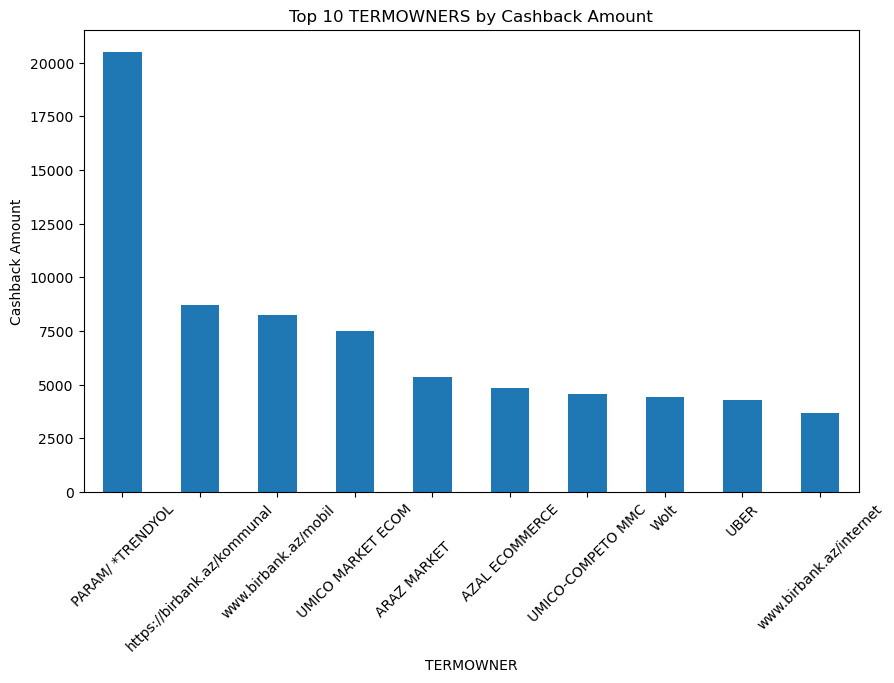

In [12]:
# Group by 'TERMOWNER' and calculate the sum of 'CASHBACK_AMOUNT'
result = df.groupby('TERMOWNER')['CASHBACK_AMOUNT'].sum()

# Sort the result in descending order
result = result.sort_values(ascending=False)

# Select the top 10 TERMOWNERS
top_10 = result.head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_10.plot(kind='bar')
plt.xlabel('TERMOWNER')
plt.ylabel('Cashback Amount')
plt.title('Top 10 TERMOWNERS by Cashback Amount')
plt.xticks(rotation=45)
plt.show()

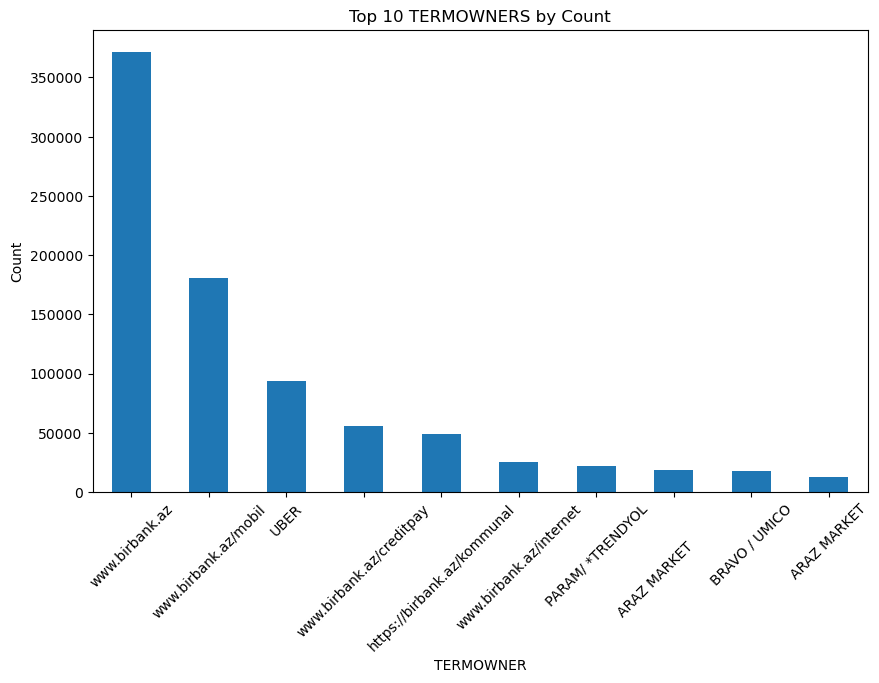

In [13]:
# Count the occurrences of each TERMOWNER
result = df['TERMOWNER'].value_counts()

# Select the top 10 TERMOWNERS
top_10 = result.head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_10.plot(kind='bar')
plt.xlabel('TERMOWNER')
plt.ylabel('Count')
plt.title('Top 10 TERMOWNERS by Count')
plt.xticks(rotation=45)
plt.show()

## MCC_GROUP

In [14]:
pd.DataFrame(df['MCC_GROUP'].value_counts())

,MCC_GROUP
RETAIL STORES,656653
SERVICE PROVIDER,432417
VARIOUS SHOPS,324247
UTILITY AND CABLE SERVICES,271575
TRANSPORT,209351
AUTOMOBILES AND VEHICLES,76455
CLOTHING STORES,44864
BUSINESS SERVICES,16062
ENTERTAINMENT,13894
PROFESSIONAL SERVICES,13400


In [15]:
pd.DataFrame(df['MCC_DESCRIPTION'].value_counts()).head()

,MCC_DESCRIPTION
"Grocery Stores, Supermarkets",605148
Member Financial Institution-Merchandise,428600
Telecommunication Serv.Includ. Local/L.D,192494
Taxicabs/Limousines,168585
"Eating Places, Restaurants",131440


In [16]:
pd.DataFrame(df.groupby(['MCC_GROUP'])['CASHBACK_AMOUNT'].sum()).sort_values(['CASHBACK_AMOUNT'],ascending=False).head()

,CASHBACK_AMOUNT
MCC_GROUP,
VARIOUS SHOPS,209714.8
RETAIL STORES,198160.5
CLOTHING STORES,60441.7
AUTOMOBILES AND VEHICLES,48327.7
PROFESSIONAL SERVICES,30352.9


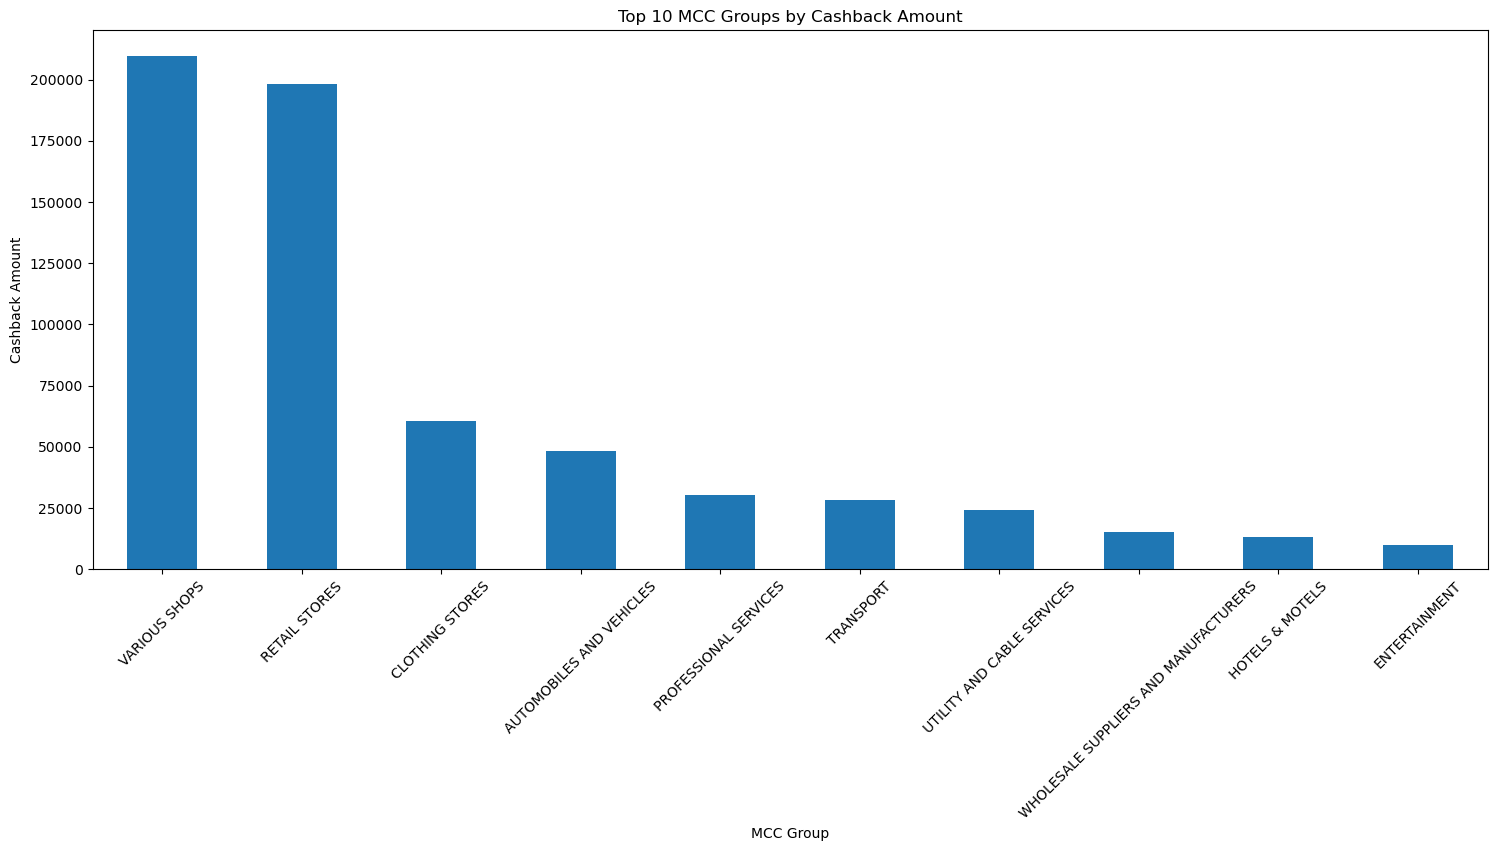

In [17]:
# Group by 'MCC_GROUP' and calculate the sum of 'CASHBACK_AMOUNT'
result = df.groupby('MCC_GROUP')['CASHBACK_AMOUNT'].sum()

# Sort the result in descending order
result = result.sort_values(ascending=False)

# Select the top 10 MCC groups
top_10 = result.head(10)

# Create a bar chart
plt.figure(figsize=(18, 7))
top_10.plot(kind='bar')
plt.xlabel('MCC Group')
plt.ylabel('Cashback Amount')
plt.title('Top 10 MCC Groups by Cashback Amount')
plt.xticks(rotation=45)
plt.show()

## HIREDATE

In [18]:
# Convert 'HIREDATE' column to datetime with the correct format
df['HIREDATE'] = pd.to_datetime(df['HIREDATE'], format='%d.%m.%Y')

# Assuming all datetime objects in the 'HIREDATE' column are in a specific timezone
desired_timezone = pytz.timezone('UTC')

# Localize 'HIREDATE' column to the desired timezone
df['HIREDATE'] = df['HIREDATE'].dt.tz_localize(desired_timezone)

# Define your current datetime
current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)

# Perform operations with the timezone-aware 'current_datetime' and 'df['HIREDATE']'
df['HIREDATE_Time_diff'] = (current_datetime - df['HIREDATE']).dt.days
df['HIREDATE_Hours'] = df['HIREDATE'].dt.hour
df['HIREDATE_Weekday'] = df['HIREDATE'].dt.weekday + 1
df['HIREDATE_Year'] = df['HIREDATE'].dt.year
df['HIREDATE_Day_of_Year'] = df['HIREDATE'].dt.day_of_year
df['HIREDATE_Month'] = df['HIREDATE'].dt.month

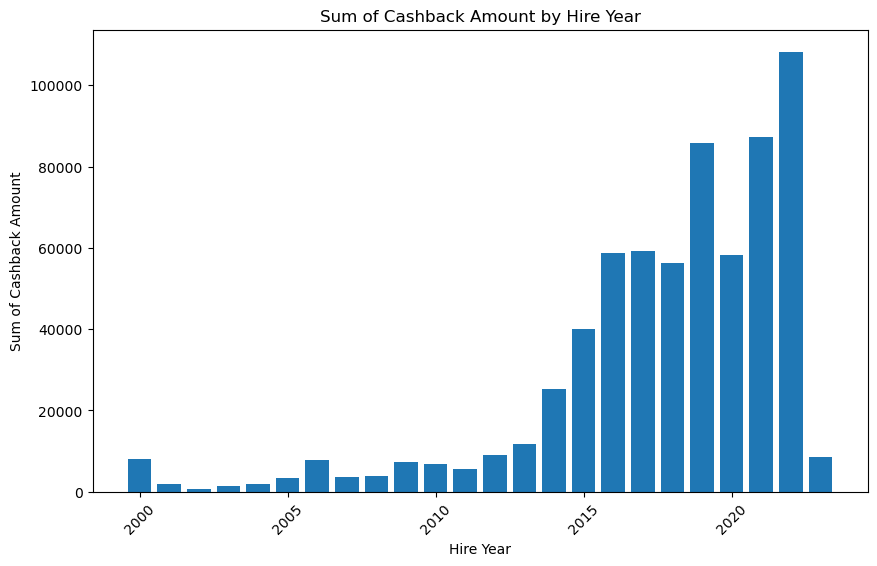

In [19]:
# Convert 'HIREDATE' column to datetime
df['HIREDATE'] = pd.to_datetime(df['HIREDATE'])

# Extract year from 'HIREDATE' column
df['HIRE_YEAR'] = df['HIREDATE'].dt.year

# Group by 'HIRE_YEAR' and calculate the sum of 'CASHBACK_AMOUNT'
result = df.groupby('HIRE_YEAR')['CASHBACK_AMOUNT'].sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values)
plt.xlabel('Hire Year')
plt.ylabel('Sum of Cashback Amount')
plt.title('Sum of Cashback Amount by Hire Year')
plt.xticks(rotation=45)
plt.show()

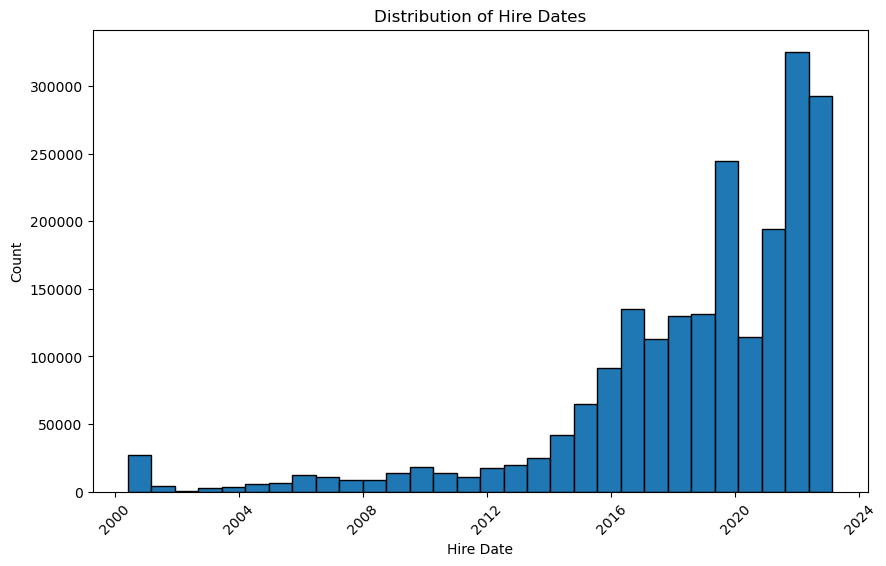

Min Hire Date: 2000-06-02 00:00:00+00:00
Max Hire Date: 2023-02-15 00:00:00+00:00
Mean Hire Date: 2018-09-04 03:16:10.362426880+00:00
Median Hire Date: 2019-09-24 00:00:00+00:00


In [20]:
# Calculate summary statistics
min_hire_date = df['HIREDATE'].min()
max_hire_date = df['HIREDATE'].max()
mean_hire_date = df['HIREDATE'].mean()
median_hire_date = df['HIREDATE'].median()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['HIREDATE'], bins=30, edgecolor='black')
plt.xlabel('Hire Date')
plt.ylabel('Count')
plt.title('Distribution of Hire Dates')
plt.xticks(rotation=45)
plt.show()

# Print summary statistics
print('Min Hire Date:', min_hire_date)
print('Max Hire Date:', max_hire_date)
print('Mean Hire Date:', mean_hire_date)
print('Median Hire Date:', median_hire_date)

## BIRTH_DATE

In [21]:
try:
    # Convert 'BIRTH_DATE' column to datetime with the correct format
    df['BIRTH_DATE'] = pd.to_datetime(df['BIRTH_DATE'], format="%d.%m.%Y")
    
    # Define the desired timezone
    desired_timezone = pytz.timezone('UTC')
    
    # Localize 'BIRTH_DATE' column to the desired timezone
    df['BIRTH_DATE'] = df['BIRTH_DATE'].dt.tz_localize(desired_timezone)
    
    # Define your current datetime
    current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)
    
    # Perform operations with the timezone-aware 'current_datetime' and 'df['BIRTH_DATE']'
    df['BIRTH_DATE_Time_diff'] = (current_datetime - df['BIRTH_DATE']).dt.days
    df['BIRTH_DATE_Hours'] = df['BIRTH_DATE'].dt.hour
    df['BIRTH_DATE_Weekday'] = df['BIRTH_DATE'].dt.weekday + 1
    df['BIRTH_DATE_Year'] = df['BIRTH_DATE'].dt.year
    df['BIRTH_DATE_Day_of_Year'] = df['BIRTH_DATE'].dt.dayofyear
    df['BIRTH_DATE_Month'] = df['BIRTH_DATE'].dt.month

except (KeyError, ValueError) as e:
    print(f"An error occurred: {str(e)}")

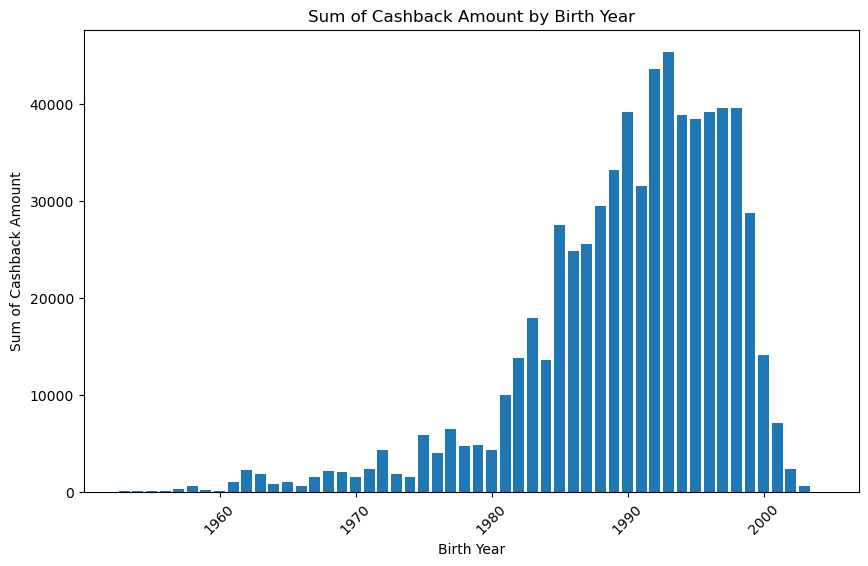

In [22]:
# Convert 'BIRTH_DATE' column to datetime
df['BIRTH_DATE'] = pd.to_datetime(df['BIRTH_DATE'])

# Extract year from 'BIRTH_DATE' column
df['YEAR'] = df['BIRTH_DATE'].dt.year

# Group by 'YEAR' and calculate the sum of 'CASHBACK_AMOUNT'
result = df.groupby('YEAR')['CASHBACK_AMOUNT'].sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values)
plt.xlabel('Birth Year')
plt.ylabel('Sum of Cashback Amount')
plt.title('Sum of Cashback Amount by Birth Year')
plt.xticks(rotation=45)
plt.show()

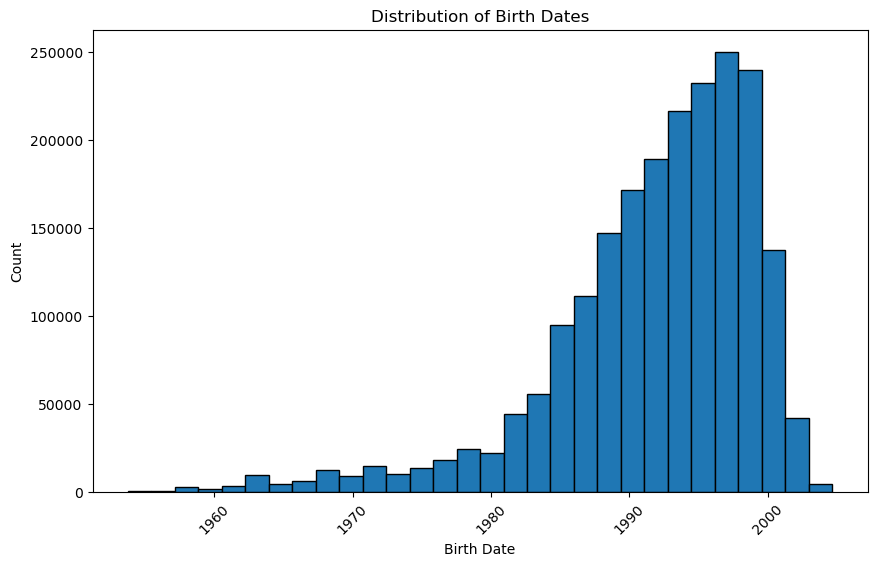

Min Birth Date: 1953-10-01 00:00:00+00:00
Max Birth Date: 2004-09-07 00:00:00+00:00
Mean Birth Date: 1991-11-27 23:00:08.786570752+00:00
Median Birth Date: 1993-04-28 00:00:00+00:00


In [23]:
# Calculate summary statistics
min_birth_date = df['BIRTH_DATE'].min()
max_birth_date = df['BIRTH_DATE'].max()
mean_birth_date = df['BIRTH_DATE'].mean()
median_birth_date = df['BIRTH_DATE'].median()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['BIRTH_DATE'], bins=30, edgecolor='black')
plt.xlabel('Birth Date')
plt.ylabel('Count')
plt.title('Distribution of Birth Dates')
plt.xticks(rotation=45)
plt.show()

# Print summary statistics
print('Min Birth Date:', min_birth_date)
print('Max Birth Date:', max_birth_date)
print('Mean Birth Date:', mean_birth_date)
print('Median Birth Date:', median_birth_date)

## BANK_TIME

In [24]:
# Convert 'BANK_TIME' column to datetime
df['BANK_TIME'] = pd.to_datetime(df['BANK_TIME'])

# Assuming all datetime objects in the 'BANK_TIME' column are in a specific timezone
desired_timezone = pytz.timezone('UTC')

# Localize 'BANK_TIME' column to the desired timezone
df['BANK_TIME'] = df['BANK_TIME'].dt.tz_localize(desired_timezone)

# Define your current datetime
current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)

# Perform operations with the timezone-aware 'current_datetime' and 'df['BANK_TIME']'
df['Time_diff'] = (current_datetime - df['BANK_TIME']).dt.days
df['Hours'] = df['BANK_TIME'].dt.hour
df['Weekday'] = df['BANK_TIME'].dt.weekday + 1
df['Year'] = df['BANK_TIME'].dt.year
df['Day_of_Year'] = df['BANK_TIME'].dt.dayofyear
df['Month'] = df['BANK_TIME'].dt.month

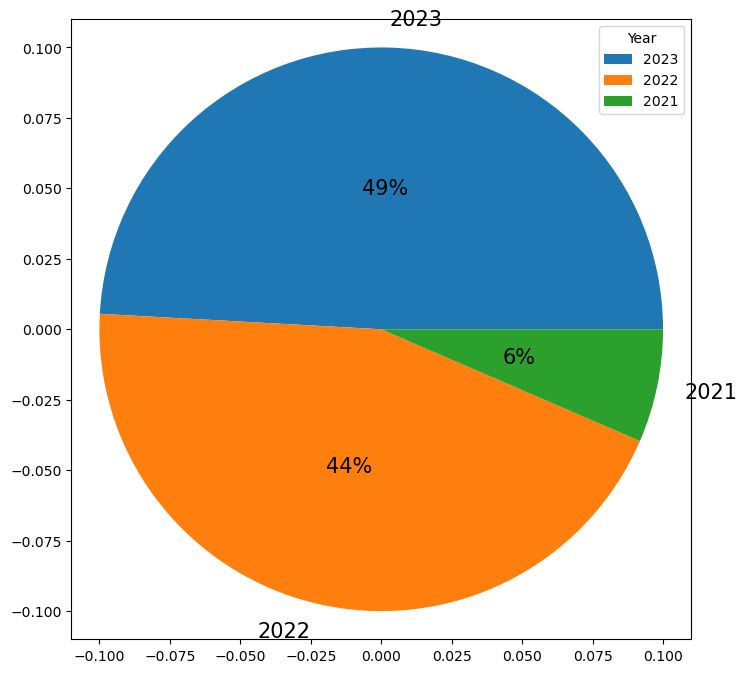

In [25]:
df_year=pd.DataFrame(df.groupby(['Year'])['CASHBACK_AMOUNT'].sum()).sort_values(['CASHBACK_AMOUNT'],ascending=False)
plt.figure(figsize=(8,9))

plt.pie(df_year.CASHBACK_AMOUNT,labels=df_year.index,shadow=False,frame=True,radius=.1, pctdistance = 0.5, autopct = "%0.0f%%",textprops={"fontsize":15} )

plt.legend(title = "Year", loc="upper right")
plt.show()

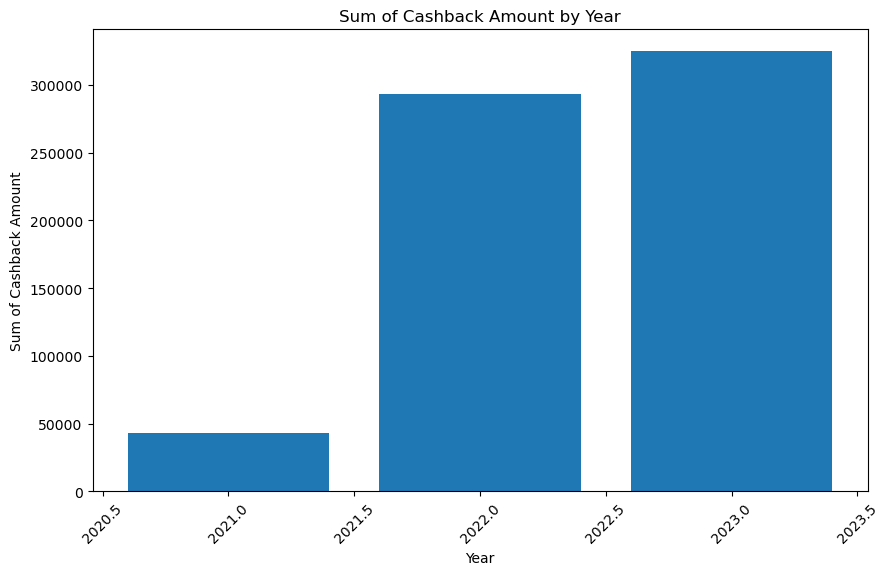

In [26]:
# Extract year from 'BANK_TIME' column
df['BANK_YEAR'] = df['BANK_TIME'].dt.year

# Group by 'BANK_YEAR' and calculate the sum of 'CASHBACK_AMOUNT'
result = df.groupby('BANK_YEAR')['CASHBACK_AMOUNT'].sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values)
plt.xlabel('Year')
plt.ylabel('Sum of Cashback Amount')
plt.title('Sum of Cashback Amount by Year')
plt.xticks(rotation=45)
plt.show()

               count      mean       std  min  25%  50%  75%    max
Year Month                                                         
2021 9       16674.0  0.397871  1.779366  0.0  0.0  0.1  0.3   75.0
     10      27210.0  0.378618  1.283448  0.0  0.0  0.1  0.3   46.5
     11      29035.0  0.422518  3.458077  0.0  0.0  0.1  0.3  426.0
     12      32175.0  0.426378  5.350467  0.0  0.0  0.1  0.3  500.0
2022 1       31689.0  0.354659  1.441852  0.0  0.0  0.1  0.3   90.6
     2       29743.0  0.332135  1.368121  0.0  0.0  0.1  0.3   96.9
     3       32913.0  0.393671  1.904230  0.0  0.0  0.1  0.3  119.7
     4       34227.0  0.362740  1.641339  0.0  0.0  0.1  0.3  120.0
     5       38165.0  0.360000  1.814105  0.0  0.0  0.1  0.3  150.0
     6       37216.0  0.411474  3.335375  0.0  0.0  0.1  0.3  471.0
     7       57700.0  0.378551  2.530492  0.0  0.0  0.1  0.3  328.3
     8       86925.0  0.325699  2.516305  0.0  0.0  0.1  0.2  494.5
     9      103702.0  0.253925  1.488028  0.0  0

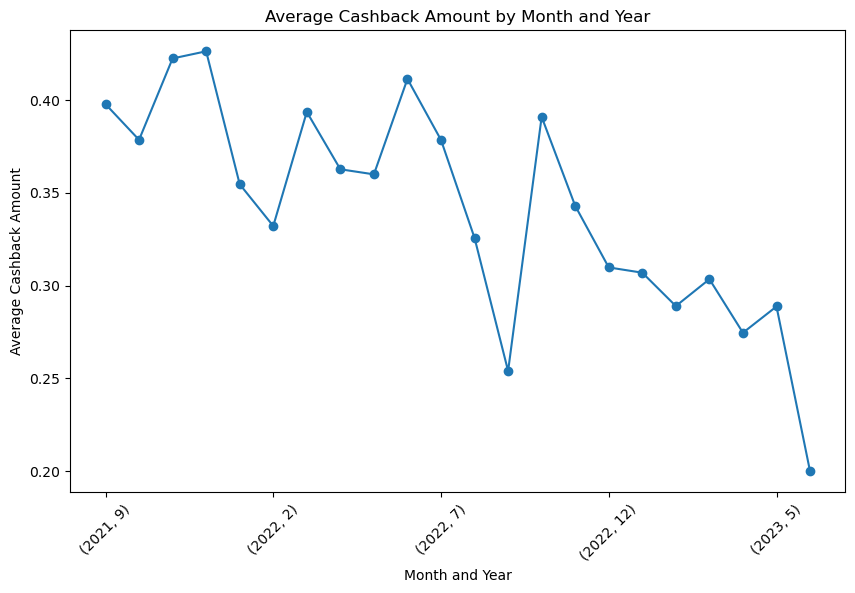

In [27]:
# Convert 'BANK_TIME' column to datetime if not already
df['BANK_TIME'] = pd.to_datetime(df['BANK_TIME'])

# Extract month and year from 'BANK_TIME' column
df['Month'] = df['BANK_TIME'].dt.month
df['Year'] = df['BANK_TIME'].dt.year

# Group data by month and year and calculate statistics
monthly_yearly_cashback_stats = df.groupby(['Year', 'Month'])['CASHBACK_AMOUNT'].describe()

# Print the statistics for each month and year
print(monthly_yearly_cashback_stats)

# Plot the average cashback amount for each month and year
plt.figure(figsize=(10, 6))
df.groupby(['Year', 'Month'])['CASHBACK_AMOUNT'].mean().plot(marker='o')
plt.xlabel('Month and Year')
plt.ylabel('Average Cashback Amount')
plt.title('Average Cashback Amount by Month and Year')
plt.xticks(rotation=45)
plt.show()

In [28]:
df = df.apply(lambda x: x.str.upper() if x.dtype == "object" else x) ## upper case all values

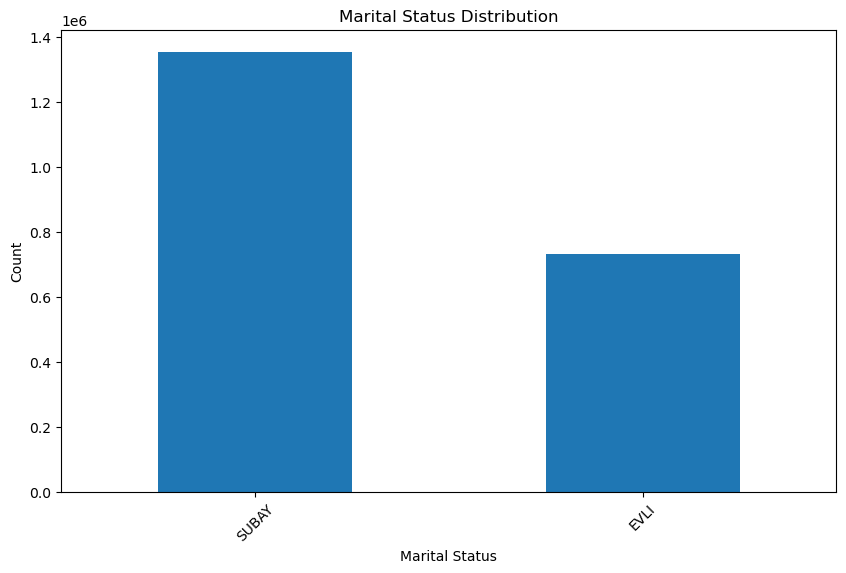

Marital Status Frequencies:
SUBAY    1354136
EVLI      732958
Name: MARSTAT, dtype: int64
Cashback Amount Summary Statistics:
count    2.087094e+06
mean     3.167936e-01
std      2.413780e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e-01
75%      2.000000e-01
max      5.000000e+02
Name: CASHBACK_AMOUNT, dtype: float64


In [29]:
# Marital Status Distribution
marstat_counts = df['MARSTAT'].value_counts()

plt.figure(figsize=(10, 6))
marstat_counts.plot(kind='bar')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Marital Status Distribution')
plt.xticks(rotation=45)
plt.show()

print('Marital Status Frequencies:')
print(marstat_counts)

print('Cashback Amount Summary Statistics:')
print(df['CASHBACK_AMOUNT'].describe())

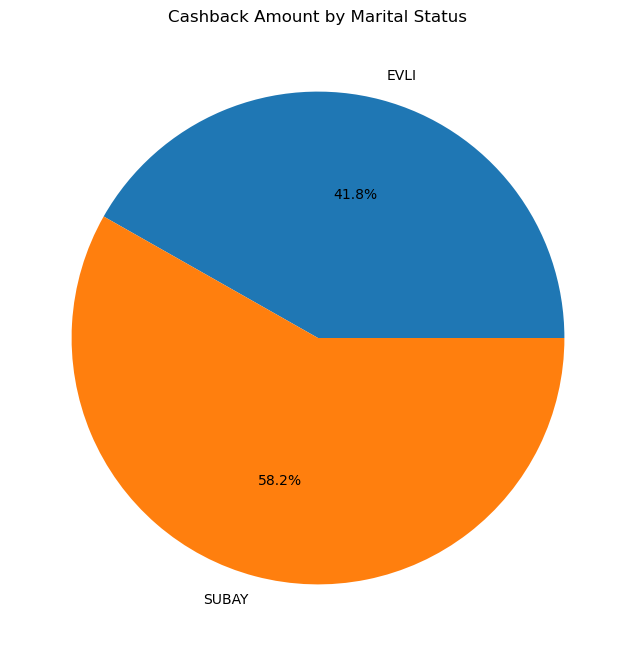

In [30]:
# Group by 'MARSTAT' and calculate the sum of 'CASHBACK_AMOUNT'
result = df.groupby('MARSTAT')['CASHBACK_AMOUNT'].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(result.values, labels=result.index, autopct='%1.1f%%')
plt.title('Cashback Amount by Marital Status')
plt.show()

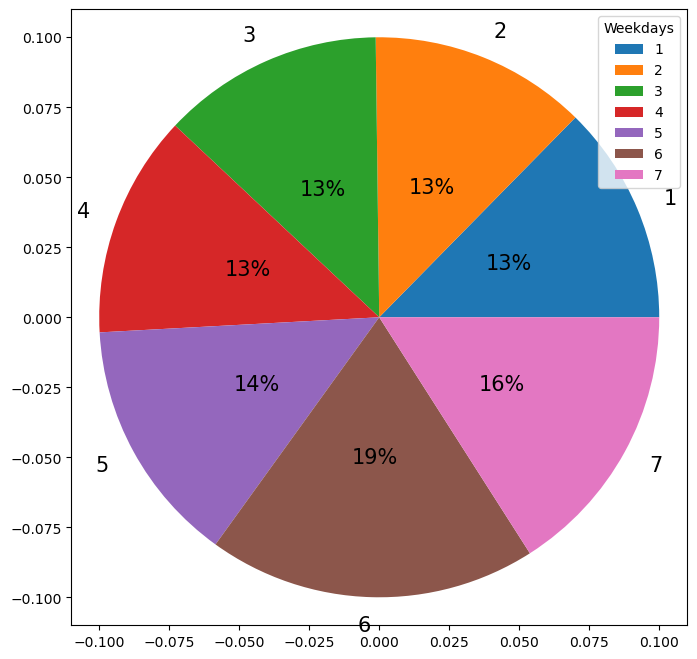

In [31]:
df_weekday=pd.DataFrame(df.groupby(['Weekday'])['CASHBACK_AMOUNT'].sum()).sort_values(['Weekday'],ascending=True)  ## sum
plt.figure(figsize=(8,8))

plt.pie(df_weekday.CASHBACK_AMOUNT,labels=df_weekday.index,shadow=False,frame=True,radius=.1, pctdistance = 0.5, autopct = "%0.0f%%",textprops={"fontsize":15} )

plt.legend(title = "Weekdays", loc="upper right")
plt.show()

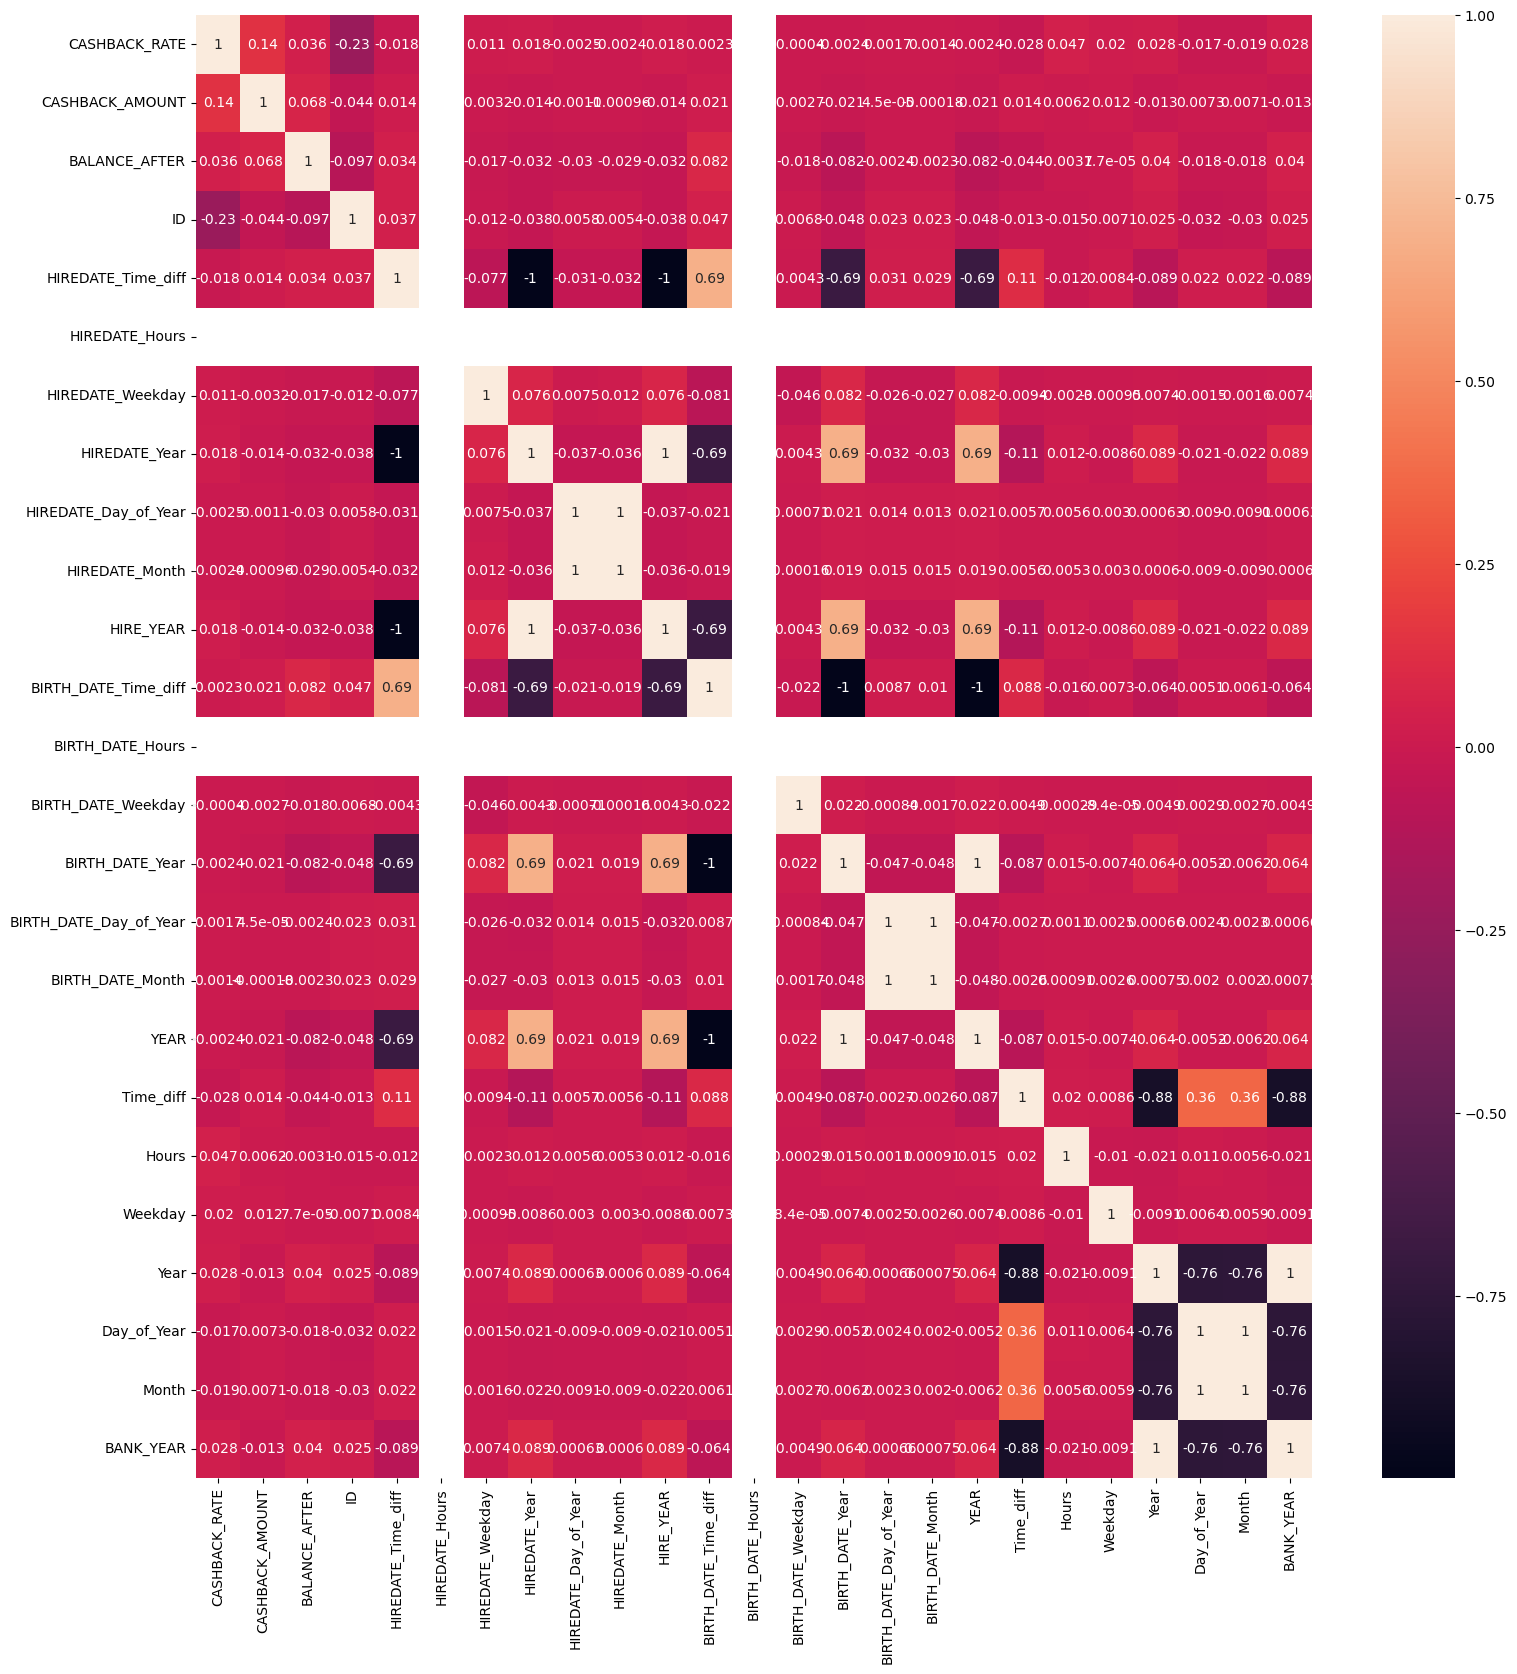

In [32]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(18, 19))
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

## Feature Engineering

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087094 entries, 0 to 2087093
Data columns (total 37 columns):
 #   Column                  Dtype              
---  ------                  -----              
 0   BANK_TIME               datetime64[ns, UTC]
 1   TERMOWNER               object             
 2   CASHBACK_RATE           float64            
 3   CASHBACK_AMOUNT         float64            
 4   BALANCE_AFTER           float64            
 5   DIRECTION               object             
 6   PIN                     object             
 7   MARSTAT                 object             
 8   BIRTH_DATE              datetime64[ns, UTC]
 9   HIREDATE                datetime64[ns, UTC]
 10  MCC                     object             
 11  MCC_DESCRIPTION         object             
 12  MCC_GROUP               object             
 13  ID                      int64              
 14  CURRENCY                object             
 15  NAME                    object             
 16  

## Dropping unused columns

In [34]:
DataFrame=df.copy()
columns_to_drop = ['BANK_TIME','BIRTH_DATE', 'HIREDATE','TERMOWNER', 'ID', 'CURRENCY', 'NAME', 'MCC_DESCRIPTION', 'MCC','DIRECTION','PIN']
DataFrame = DataFrame.drop(columns=columns_to_drop)

In [35]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087094 entries, 0 to 2087093
Data columns (total 26 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   CASHBACK_RATE           float64
 1   CASHBACK_AMOUNT         float64
 2   BALANCE_AFTER           float64
 3   MARSTAT                 object 
 4   MCC_GROUP               object 
 5   HIREDATE_Time_diff      int64  
 6   HIREDATE_Hours          int64  
 7   HIREDATE_Weekday        int64  
 8   HIREDATE_Year           int64  
 9   HIREDATE_Day_of_Year    int64  
 10  HIREDATE_Month          int64  
 11  HIRE_YEAR               int64  
 12  BIRTH_DATE_Time_diff    int64  
 13  BIRTH_DATE_Hours        int64  
 14  BIRTH_DATE_Weekday      int64  
 15  BIRTH_DATE_Year         int64  
 16  BIRTH_DATE_Day_of_Year  int64  
 17  BIRTH_DATE_Month        int64  
 18  YEAR                    int64  
 19  Time_diff               int64  
 20  Hours                   int64  
 21  Weekday                 int64  

In [36]:
# Select the object columns to convert to dummy variables
object_columns = ['MARSTAT', 'MCC_GROUP']

# Convert object columns to dummy variables
dummy_df = pd.get_dummies(DataFrame[object_columns], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
DataFrame = pd.concat([DataFrame, dummy_df], axis=1)

# Drop the original object columns
DataFrame = DataFrame.drop(object_columns, axis=1)

In [37]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087094 entries, 0 to 2087093
Data columns (total 44 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   CASHBACK_RATE                                    float64
 1   CASHBACK_AMOUNT                                  float64
 2   BALANCE_AFTER                                    float64
 3   HIREDATE_Time_diff                               int64  
 4   HIREDATE_Hours                                   int64  
 5   HIREDATE_Weekday                                 int64  
 6   HIREDATE_Year                                    int64  
 7   HIREDATE_Day_of_Year                             int64  
 8   HIREDATE_Month                                   int64  
 9   HIRE_YEAR                                        int64  
 10  BIRTH_DATE_Time_diff                             int64  
 11  BIRTH_DATE_Hours                                 int64  
 12  BIRTH_DATE_Wee

## Modelling

In [38]:
X = DataFrame.drop('CASHBACK_AMOUNT', axis=1)
y = DataFrame['CASHBACK_AMOUNT']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
%%time
model =  RandomForestRegressor()
model.fit(X_train, y_train)

CPU times: total: 58min 9s
Wall time: 1h 13min 29s


RandomForestRegressor()

## Accuracy metrics

In [46]:
%%time
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Perform cross-validation and calculate the mean score
scores = cross_val_score(model, X, y, cv=5)
mean_score = scores.mean()

# Print the mean score
print(f"Mean cross-validation score: {mean_score}")

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R^2): {r2}")

Mean cross-validation score: -0.4433972394706608
Mean Squared Error (MSE): 3.229615146301607
Root Mean Squared Error (RMSE): 1.7971130032086482
Mean Absolute Error (MAE): 0.2774434393273557
R-squared (R^2): 0.45271778566663723
CPU times: total: 3h 25min 46s
Wall time: 4h 25min 29s


## Deployment

In [74]:
%%time
def predict_cashback_summary(df, days):
    # Create a copy of the DataFrame
    df = df.copy()

    # Drop unused columns
    columns_to_drop = ['TERMOWNER', 'ID', 'CURRENCY', 'NAME', 'MCC_DESCRIPTION', 'MCC', 'DIRECTION', 'PIN']
    df = df.drop(columns_to_drop, axis=1)

    # Replace null values with mode
    mode_values = df.mode().iloc[0]
    df = df.fillna(mode_values)

    # Convert date columns to datetime
    date_columns = ['HIREDATE', 'BIRTH_DATE', 'BANK_TIME']
    for column in date_columns:
        df[column] = pd.to_datetime(df[column])

    # Extract features from date columns
    current_date = pd.to_datetime('now').tz_localize(df['BANK_TIME'].dt.tz)
    df['HIREDATE_Time_diff'] = (current_date - df['HIREDATE']).dt.days
    df['HIREDATE_Hours'] = df['HIREDATE'].dt.hour
    df['HIREDATE_Weekday'] = df['HIREDATE'].dt.weekday
    df['HIREDATE_Year'] = df['HIREDATE'].dt.year
    df['HIREDATE_Day_of_Year'] = df['HIREDATE'].dt.dayofyear
    df['HIREDATE_Month'] = df['HIREDATE'].dt.month

    df['BIRTH_DATE_Time_diff'] = (current_date - df['BIRTH_DATE']).dt.days
    df['BIRTH_DATE_Hours'] = df['BIRTH_DATE'].dt.hour
    df['BIRTH_DATE_Weekday'] = df['BIRTH_DATE'].dt.weekday
    df['BIRTH_DATE_Year'] = df['BIRTH_DATE'].dt.year
    df['BIRTH_DATE_Day_of_Year'] = df['BIRTH_DATE'].dt.dayofyear
    df['BIRTH_DATE_Month'] = df['BIRTH_DATE'].dt.month

    df['BANK_TIME_Time_diff'] = (current_date - df['BANK_TIME']).dt.days
    df['BANK_TIME_Hours'] = df['BANK_TIME'].dt.hour
    df['BANK_TIME_Weekday'] = df['BANK_TIME'].dt.weekday
    df['BANK_TIME_Year'] = df['BANK_TIME'].dt.year
    df['BANK_TIME_Day_of_Year'] = df['BANK_TIME'].dt.dayofyear
    df['BANK_TIME_Month'] = df['BANK_TIME'].dt.month

    # Drop date columns
    df = df.drop(date_columns, axis=1)

    # Encode 'MARSTAT' and 'MCC_GROUP' columns as dummy variables
    df = pd.get_dummies(df, columns=['MARSTAT', 'MCC_GROUP'], drop_first=True)

    # Split the data into features (X) and target (y)
    X = df.drop('CASHBACK_AMOUNT', axis=1)
    y = df['CASHBACK_AMOUNT']

    # Initialize the Random Forest model
    model = RandomForestRegressor()

    # Fit the model on the data
    model.fit(X, y)

    # Predict cashback amounts for the next 'days' days
    future_dates = pd.date_range(df['BANK_TIME'].max(), periods=days, freq='D')
    future_features = pd.DataFrame(index=future_dates, columns=X.columns)
    future_features.fillna(0, inplace=True)
    future_cashback = model.predict(future_features)

    return future_cashback

CPU times: total: 0 ns
Wall time: 0 ns


In [75]:
%%time
df_2=df.copy()
summary =predict_cashback_summary(df_2,30)

KeyError: 'BANK_TIME'

## Comparing results

In [80]:
df['BANK_TIME'] = pd.to_datetime(df['BANK_TIME'])

# Filter the DataFrame for the specified date range
filtered_df = df[(df['BANK_TIME'] >= pd.to_datetime('2023-05-01')) & (df['BANK_TIME'] <= pd.to_datetime('2023-05-31'))]

# Group by month and calculate the sum of cashback amounts
result = filtered_df.groupby(filtered_df['BANK_TIME'].dt.strftime('%B'))['CASHBACK_AMOUNT'].sum().reset_index()

# Rename the columns
result = result.rename(columns={'BANK_TIME': 'MONTH', 'CASHBACK_AMOUNT': 'CASHBACK_AMOUNT'})

result
summary

,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,HIREDATE_Time_diff,HIREDATE_Hours,HIREDATE_Weekday,HIREDATE_Year,HIREDATE_Day_of_Year,HIREDATE_Month,HIRE_YEAR,...,MCC_GROUP_PROFESSIONAL SERVICES,MCC_GROUP_RENT-A-CAR,MCC_GROUP_REPAIR SERVICES,MCC_GROUP_RETAIL STORES,MCC_GROUP_SALES BY MAIL / PHONE,MCC_GROUP_SERVICE PROVIDER,MCC_GROUP_TRANSPORT,MCC_GROUP_UTILITY AND CABLE SERVICES,MCC_GROUP_VARIOUS SHOPS,MCC_GROUP_WHOLESALE SUPPLIERS AND MANUFACTURERS
0,0.3,0.0,0.0,3126,0,1,2014,315,11,2014,...,0,0,0,0,0,0,0,1,0,0
1,0.5,0.1,0.1,3061,0,3,2015,15,1,2015,...,0,0,0,0,0,0,0,1,0,0
2,0.5,0.0,0.0,2816,0,3,2015,260,9,2015,...,0,0,0,0,0,0,0,1,0,0
3,0.5,0.0,0.0,3259,0,1,2014,182,7,2014,...,0,0,0,0,0,0,0,1,0,0
4,0.5,0.0,0.0,1726,0,1,2018,254,9,2018,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087089,1.5,0.2,0.5,3091,0,1,2014,350,12,2014,...,0,0,0,0,0,0,0,0,1,0
2087090,0.0,0.0,9.6,6297,0,1,2006,66,3,2006,...,0,0,0,0,0,1,0,0,0,0
2087091,0.0,0.0,1.4,529,0,1,2021,355,12,2021,...,0,0,0,0,0,1,0,0,0,0
2087092,1.5,0.1,48.8,1212,0,4,2020,38,2,2020,...,0,0,0,0,0,0,0,0,1,0


 ## Feature importance

In [77]:
feature_names= X.columns
importance_scores = model.feature_importances_
sorted_indices = importance_scores.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_scores = importance_scores[sorted_indices]

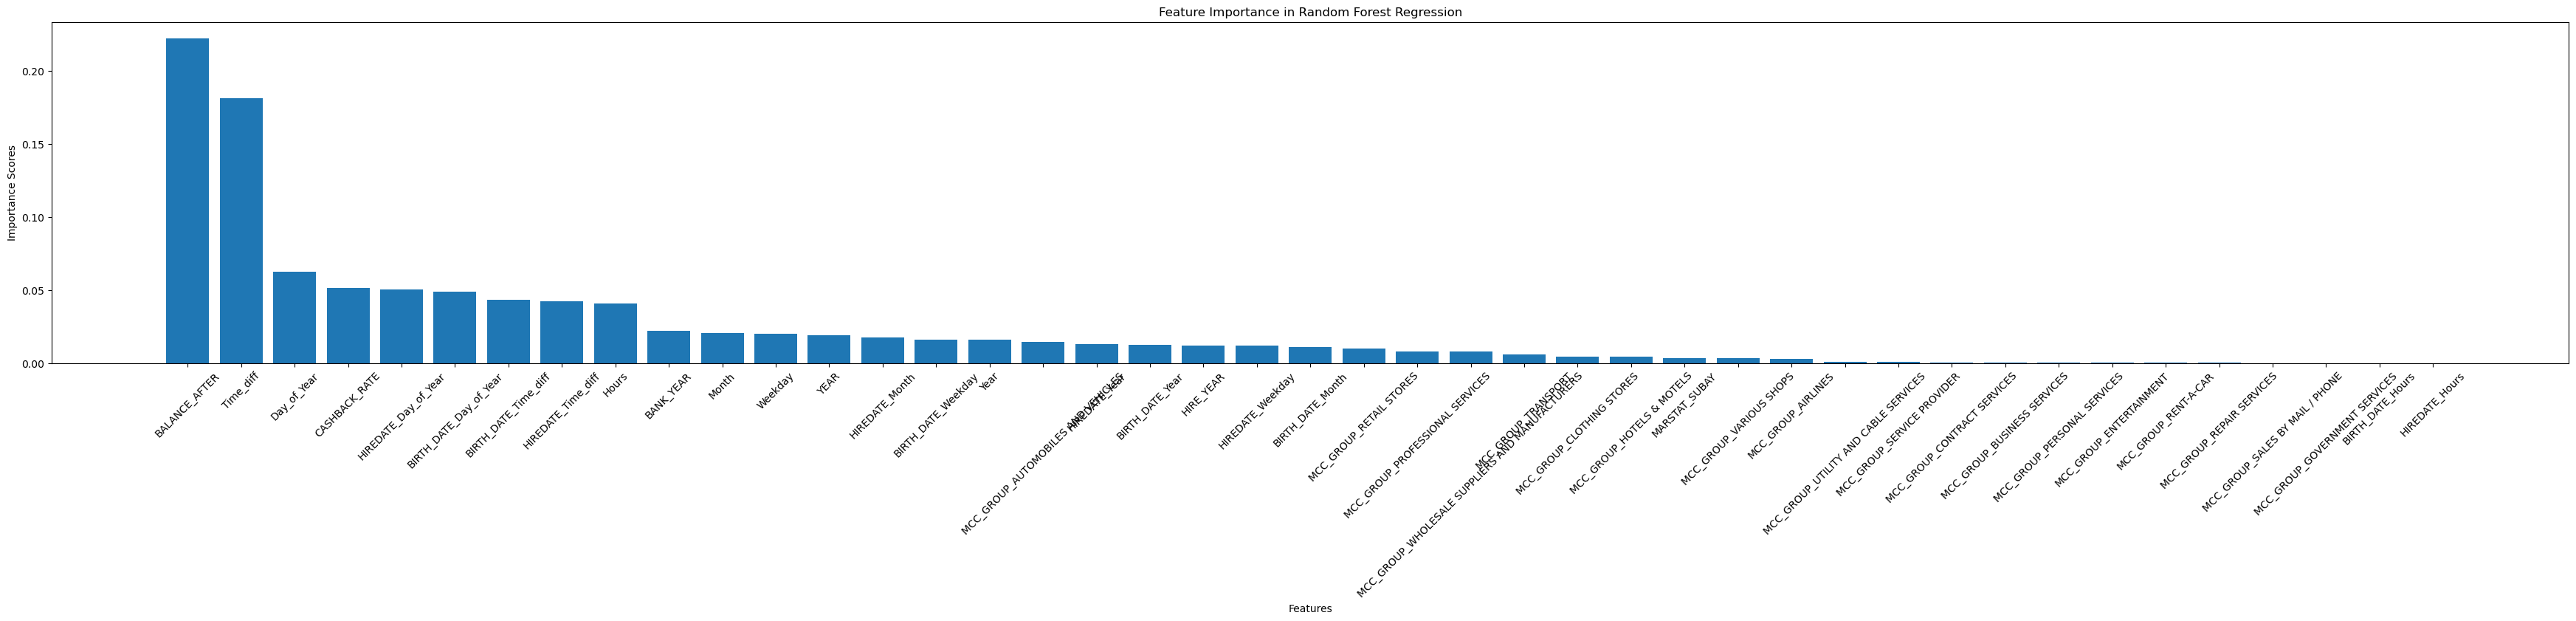

In [82]:
# Plot feature importance
plt.figure(figsize=(44, 6))
plt.bar(range(len(sorted_importance_scores)), sorted_importance_scores, tick_label=sorted_feature_names)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance in Random Forest Regression')
plt.xticks(rotation=45)
plt.show()